# Evaluation notebook for comparing different models

This notebook provides two ways of comparing models

1. Visualization of precipitation propagation plots
2. Evaluation over custom datasets using predetermined metrics

In [1]:
# h5_dataset_location = "../data/events/5.h5"
h5_dataset_location = "temp/ghana_imerg_2011_2020_Oct.h5"
ir_h5_dataset_location = "temp/ghana_IR_2011_2020_oct.h5"

metadata_location = "../data/events/1/metadata.json"
import json

with open(metadata_location) as jsonfile:
    geodata_dict = json.loads(jsonfile.read())

dataset_type = 'ghana_monthly' # ghana, ghana_monthly and wa
from servir.core.data_provider import IMERGDataModule

data_provider =  IMERGDataModule(
        forecast_steps = 12,
        history_steps = 8,
        imerg_filename = h5_dataset_location,
        ir_filename = ir_h5_dataset_location,
        batch_size = 32,
        image_shape = (64,64),
        normalize_data=False,
        dataset = dataset_type)

data_loader = data_provider.test_dataloader()

crps_dict = {'dgmr':{},
             'dgmr_ir':{},
             'steps':{},
            }
psd_dict = {'dgmr':{},
             'dgmr_ir':{},
             'steps':{},
            }
csi_dict = {'dgmr':{},
             'dgmr_ir':{},
             'steps':{},
            }

for j in range(12):
    crps_dict['dgmr'][str(j)] = []
    crps_dict['dgmr_ir'][str(j)] = []
    crps_dict['steps'][str(j)] = []
    
    psd_dict['dgmr'][str(j)] = []
    psd_dict['dgmr_ir'][str(j)] = []
    psd_dict['steps'][str(j)] = []
    
    csi_dict['dgmr'][str(j)] = []
    csi_dict['dgmr_ir'][str(j)] = []
    csi_dict['steps'][str(j)] = []    

original shape (14880, 64, 64)
Precipitation Dataset input shape:  (1469, 8, 1, 64, 64)
Precipitation Dataset output shape:  (1469, 12, 1, 64, 64)
IR original shape (29760, 64, 64)
IR Dataset input shape:  (1469, 16, 1, 64, 64)
IR Dataset output shape:  (1469, 15, 1, 64, 64)


## Evaluation for ensemble predictions

In [2]:
from servir.core.model_picker import ModelPicker
from pysteps.verification.probscores import CRPS
import numpy as np
import torch

model_type = 'steps'
model_config_location = 'configs/gh_imerg/PySTEPS.py'
model_save_location = None
use_gpu = False

# model_type = 'linda'
# model_config_location = 'configs/gh_imerg/LINDA.py'
# model_save_location = None
# use_gpu = False

# model_type = 'dgmr'
# model_config_location = 'configs/gh_imerg/DGMR.py'
# model_save_location = 'temp/DGMR-epoch=13.ckpt'
# use_gpu = False

# model_type = 'dgmr_ir'
# model_config_location = 'configs/gh_imerg/DGMR.py'
# model_save_location = 'temp/DGMR_IR-epoch=01.ckpt'
# use_gpu = False


model_picker = ModelPicker(model_type, model_config_location,model_save_location, use_gpu)
model_picker.load_model()

for index, data_sample_batch in enumerate(data_loader):
    x, x_ir, y = data_sample_batch
    print("starting predictions for batch {}".format(index))
    if model_type in ['steps', 'lagrangian', 'naive', 'linda']:
        x = x.numpy()[:,:,0,:,:]
        y = y.numpy()[:,:,0,:,:]

        for data_sample_index in range(len(x)):
            try:
                predicted_output = model_picker.predict(x[data_sample_index])
                for j in range(12):
                    crps_dict[model_type][str(j)].append(CRPS(predicted_output[:,0:j,: ], y[data_sample_index][0:j]))
            except:
                pass
    elif model_type in ['dgmr']:
        predicted_output = torch.tensor(model_picker.predict(x))
        rearanged_output = predicted_output.numpy().transpose(1, 0, 2, 3, 4, 5)[:,:,:,0,:,:]
        for data_sample_index in range(len(rearanged_output)):
            output = rearanged_output[data_sample_index]
            for j in range(12):
                crps_dict[model_type][str(j)].append(CRPS(output[:,0:j,:,:], y.numpy()[:,:,0,:,:][data_sample_index][0:j,:,:]))
            
    elif model_type in ['dgmr_ir']:
        predicted_output = torch.tensor(model_picker.predict(x, x_ir))
        print(predicted_output.shape)

        rearanged_output = predicted_output.numpy().transpose(1, 0, 2, 3, 4, 5)[:,:,:,0,:,:]
        for data_sample_index in range(len(rearanged_output)):
            output = rearanged_output[data_sample_index]
            for j in range(12):
                crps_dict[model_type][str(j)].append(CRPS(output[:,0:j,:,:], y.numpy()[:,:,0,:,:][data_sample_index][0:j,:,:]))
    if index == 4:
        break

Pysteps configuration file found at: /volume/NFS/aa3328/miniconda3/envs/tito_env/lib/python3.12/site-packages/pysteps/pystepsrc



/volume/NFS/aa3328/miniconda3/envs/tito_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading config from configs/gh_imerg/PySTEPS.py ...


/volume/NFS/aa3328/miniconda3/envs/tito_env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/volume/NFS/aa3328/miniconda3/envs/tito_env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tenso

starting predictions for batch 0
Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 64x64
km/pixel:         10
time step:        30 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
ensemble size:            20
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
---------

/volume/NFS/aa3328/miniconda3/envs/tito_env/lib/python3.12/site-packages/pysteps/utils/cleansing.py:241: UserWarning: Singular matrix during outlier detection
  warnings.warn(f"{err} during outlier detection")


done.
Computing nowcast for time step 2... done.
Computing nowcast for time step 3... done.
Computing nowcast for time step 4... done.
Computing nowcast for time step 5... done.
Computing nowcast for time step 6... done.
Computing nowcast for time step 7... done.
Computing nowcast for time step 8... done.
Computing nowcast for time step 9... done.
Computing nowcast for time step 10... done.
Computing nowcast for time step 11... done.
Computing nowcast for time step 12... done.
Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 64x64
km/pixel:         10
time step:        30 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
------

/tmp/ipykernel_43458/853822392.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([crps_dict['dgmr_ir'], crps_dict['dgmr'], crps_dict['steps']], labels=['dgmr_ir', 'dgmr', 'steps'])
/tmp/ipykernel_43458/853822392.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


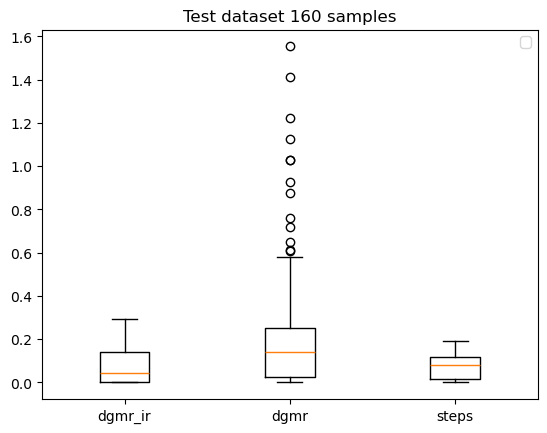

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot([crps_dict['dgmr_ir'], crps_dict['dgmr'], crps_dict['steps']], labels=['dgmr_ir', 'dgmr', 'steps'])
plt.title("Test dataset {} samples".format(len(crps_dict['dgmr'])))
# plt.boxplot(crps_dict['steps'], label='steps', positions=[1])
plt.legend()
plt.show()

In [1]:
import numpy as np

dgmr_crps_dict = np.load('dgmr_crps.npy', allow_pickle=True).item()
dgmr_ir_crps_dict = np.load('dgmr_ir_crps.npy', allow_pickle=True).item()
steps_crps_dict = np.load('steps_crps.npy', allow_pickle=True).item()


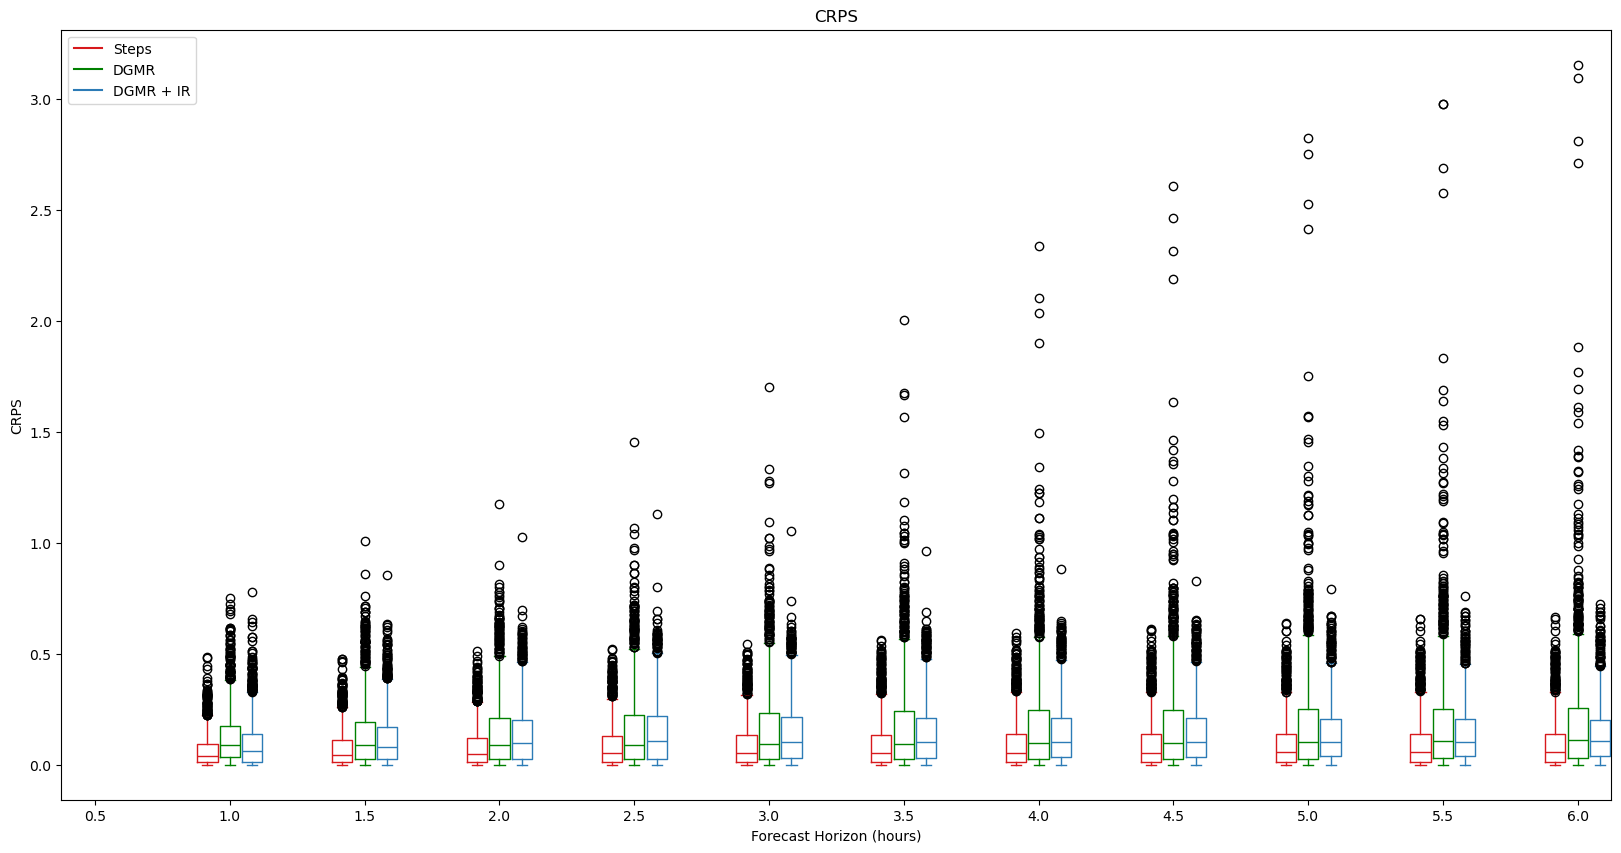

In [3]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(20,10)) 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
for i in range(12):
    # sns.boxplot(x = i*np.ones_like(vals[i]), y = vals[i])
    bp_cnv_lstm = plt.boxplot([steps_crps_dict[str(i)]],widths = 0.9,  positions=[0+i*6])
    set_box_color(bp_cnv_lstm, '#D7191C')
    bp_cnv_lstm_relu = plt.boxplot([dgmr_crps_dict[str(i)]],widths = 0.9,  positions=[1+i*6])
    set_box_color(bp_cnv_lstm_relu, '#008000')
    bp_naive = plt.boxplot([dgmr_ir_crps_dict[str(i)]],widths = 0.9,  positions=[2+i*6])
    set_box_color(bp_naive, '#2C7BB6')
    
    # ,naive_fss[i], 
                #  lagrangian_fss[i],1+i*3, 2+i*3
     # colors are from http://colorbrewer2.org/
    # set_box_color(bpr, '#')
plt.xticks(range(1, 12 * 6 + 1, 6), [str(i/2 + 0.5) for i in range(12)])
plt.plot([], c='#D7191C', label='Steps')
plt.plot([], c='#008000', label='DGMR')
plt.plot([], c='#2C7BB6', label='DGMR + IR')

plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("CRPS")
plt.title("CRPS")

plt.legend()

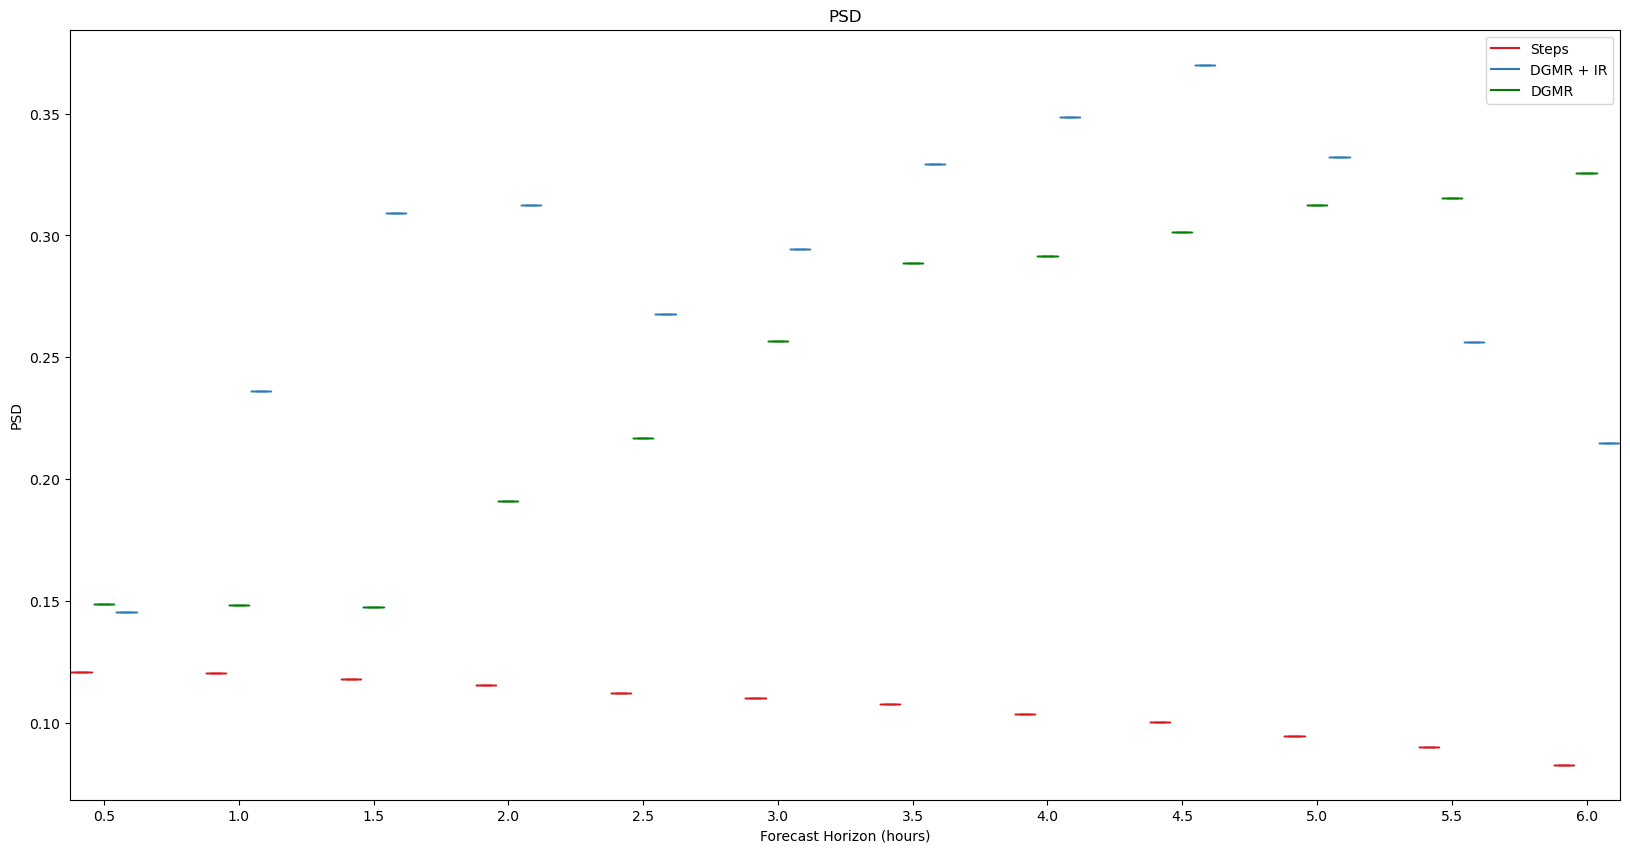

In [17]:
import matplotlib.pyplot as plt
import numpy as np


dgmr_psd_dict = np.load('dgmr_rapsd.npy', allow_pickle=True).item()
dgmr_ir_psd_dict = np.load('dgmr_ir_rapsd.npy', allow_pickle=True).item()
steps_psd_dict = np.load('steps_rapsd.npy', allow_pickle=True).item()

fig, ax = plt.subplots(figsize=(20,10)) 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
for i in range(12):
    # sns.boxplot(x = i*np.ones_like(vals[i]), y = vals[i])
    bp_cnv_lstm = plt.boxplot([np.mean(steps_psd_dict[str(i)])],widths = 0.9,  positions=[0+i*6])
    set_box_color(bp_cnv_lstm, '#D7191C')
    bp_naive = plt.boxplot([np.mean(dgmr_ir_psd_dict[str(i)])],widths = 0.9,  positions=[2+i*6])
    set_box_color(bp_naive, '#2C7BB6')
    bp_cnv_lstm_relu = plt.boxplot([np.mean(dgmr_psd_dict[str(i)])],widths = 0.9,  positions=[1+i*6])
    set_box_color(bp_cnv_lstm_relu, '#008000')
    
    # ,naive_fss[i], 
                #  lagrangian_fss[i],1+i*3, 2+i*3
     # colors are from http://colorbrewer2.org/
    # set_box_color(bpr, '#')
plt.xticks(range(1, 12 * 6 + 1, 6), [str(i/2 + 0.5) for i in range(12)])
plt.plot([], c='#D7191C', label='Steps')
plt.plot([], c='#2C7BB6', label='DGMR + IR')
plt.plot([], c='#008000', label='DGMR')

plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("PSD")
plt.title("PSD")

plt.legend()



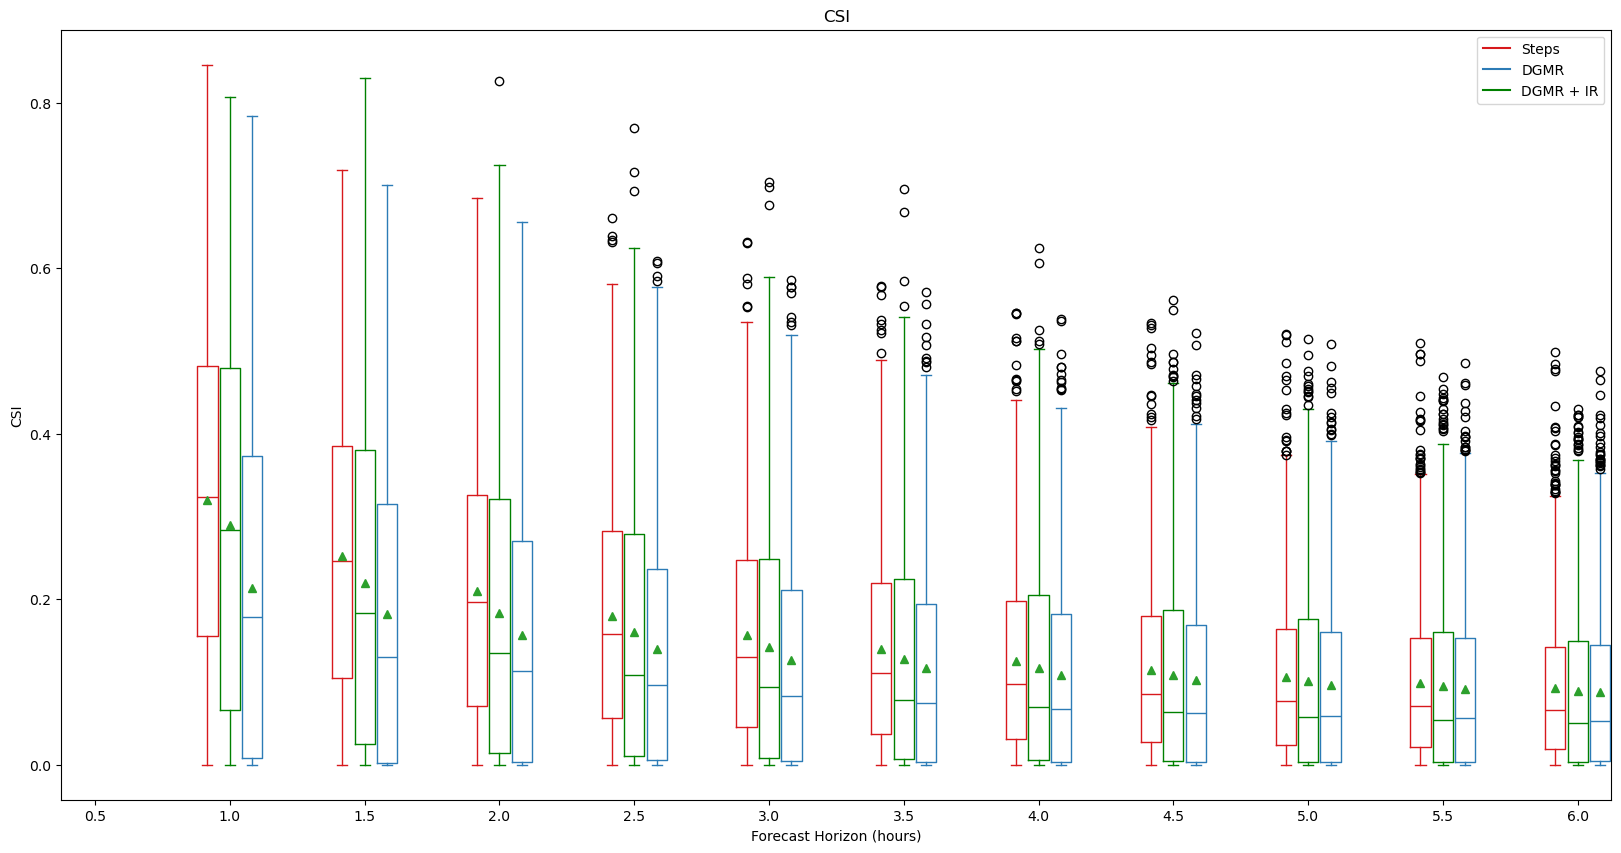

In [34]:
import matplotlib.pyplot as plt
import numpy as np


thr = 1

dgmr_csi_dict = np.load('dgmr_{}_csi.npy'.format(str(thr)), allow_pickle=True).item()
dgmr_ir_csi_dict = np.load('dgmr_ir_{}_csi.npy'.format(str(thr)), allow_pickle=True).item()
steps_csi_dict = np.load('steps_{}_csi.npy'.format(str(thr)), allow_pickle=True).item()


fig, ax = plt.subplots(figsize=(20,10)) 
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
for i in range(12):
    # sns.boxplot(x = i*np.ones_like(vals[i]), y = vals[i])
    bp_data = np.array([x for x in steps_csi_dict[str(i)]])
    bp_data = bp_data[~np.isnan(bp_data)]
    bp_cnv_lstm = plt.boxplot([bp_data],widths = 0.9,  positions=[0+i*6], showmeans=True)
    set_box_color(bp_cnv_lstm, '#D7191C')
    bp_data = np.array([x['CSI'] for x in dgmr_ir_csi_dict[str(i)]])
    bp_data = bp_data[~np.isnan(bp_data)]
    bp_cnv_lstm_relu = plt.boxplot([bp_data],widths = 0.9,  positions=[1+i*6], showmeans=True)
    set_box_color(bp_cnv_lstm_relu, '#008000')
    bp_data = np.array([x['CSI'] for x in dgmr_csi_dict[str(i)]])
    bp_data = bp_data[~np.isnan(bp_data)]
    bp_naive = plt.boxplot([bp_data],widths = 0.9,  positions=[2+i*6], showmeans=True)
    set_box_color(bp_naive, '#2C7BB6')
    
    # ,naive_fss[i], 
                #  lagrangian_fss[i],1+i*3, 2+i*3
     # colors are from http://colorbrewer2.org/
    # set_box_color(bpr, '#')
plt.xticks(range(1, 12 * 6 + 1, 6), [str(i/2 + 0.5) for i in range(12)])
plt.plot([], c='#D7191C', label='Steps')
plt.plot([], c='#2C7BB6', label='DGMR')
plt.plot([], c='#008000', label='DGMR + IR')

plt.xlabel("Forecast Horizon (hours)")
plt.ylabel("CSI")
plt.title("CSI")

plt.legend()



In [21]:
[x for x in steps_csi_dict[str(i)]]

[np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float6

In [ ]:
from servir.core.model_picker import ModelPicker
from pysteps.verification.probscores import CRPS
from pysteps.utils.spectral import rapsd
from pysteps.verification.detcatscores import det_cat_fct

import numpy as np
import torch

model_type = 'steps'
model_config_location = 'configs/gh_imerg/PySTEPS.py'
model_save_location = None
use_gpu = False

# model_type = 'linda'
# model_config_location = 'configs/gh_imerg/LINDA.py'
# model_save_location = None
# use_gpu = False

# model_type = 'dgmr'
# model_config_location = 'configs/gh_imerg/DGMR.py'
# model_save_location = 'temp/DGMR-epoch=13.ckpt'
# use_gpu = False

# model_type = 'dgmr_ir'
# model_config_location = 'configs/gh_imerg/DGMR.py'
# model_save_location = 'temp/DGMR_IR-epoch=01.ckpt'
# use_gpu = False


model_picker = ModelPicker(model_type, model_config_location,model_save_location, use_gpu)
model_picker.load_model(get_ensemble=False)

for index, data_sample_batch in enumerate(data_loader):
    x, x_ir, y = data_sample_batch
    print("starting predictions for batch {}".format(index))
    if model_type in ['steps', 'lagrangian', 'naive', 'linda']:
        x = x.numpy()[:,:,0,:,:]
        y = y.numpy()[:,:,0,:,:]

        for data_sample_index in range(len(x)):
            try:
                predicted_output = model_picker.predict(x[data_sample_index])
                # crps_dict[model_type].append(CRPS(predicted_output[:,:,: ], y[data_sample_index]))
                csi_dict[model_type].append(det_cat_fct(predicted_output[:,:,: ][0], y[data_sample_index], thr=1)['CSI'])
                for j in range(12):
                    psd_dict[model_type].append(rapsd(predicted_output[:,:,: ][0][j]))
            except:
                pass
    elif model_type in ['dgmr']:
        predicted_output = torch.tensor(model_picker.predict(x))
        print(predicted_output.shape)

        rearanged_output = predicted_output.numpy().transpose(1, 0, 2, 3, 4, 5)[:,:,:,0,:,:]
        for data_sample_index in range(len(rearanged_output)):
            output = rearanged_output[data_sample_index]
            csi_dict[model_type].append(det_cat_fct(output[0], y.numpy()[:,:,0,:,:][data_sample_index], thr=1)['CSI'])
            for j in range(12):
                psd_dict[model_type].append(rapsd(output[0][j]))
    elif model_type in ['dgmr_ir']:
        predicted_output = torch.tensor(model_picker.predict(x, x_ir))
        print(predicted_output.shape)

        rearanged_output = predicted_output.numpy().transpose(1, 0, 2, 3, 4, 5)[:,:,:,0,:,:]
        for data_sample_index in range(len(rearanged_output)):
            output = rearanged_output[data_sample_index]
            csi_dict[model_type].append(det_cat_fct(output[0], y.numpy()[:,:,0,:,:][data_sample_index], thr=1)['CSI'])
            for j in range(12):
                psd_dict[model_type].append(rapsd(output[0][j]))
    if index == 1:
        break

loading config from configs/gh_imerg/PySTEPS.py ...


/volume/NFS/aa3328/miniconda3/envs/tito_env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
/volume/NFS/aa3328/miniconda3/envs/tito_env/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tenso

starting predictions for batch 0
Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 64x64
km/pixel:         10
time step:        30 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
ensemble size:            1
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
----------

Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 64x64
km/pixel:         10
time step:        30 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
ensemble size:            1
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
|

/volume/NFS/aa3328/miniconda3/envs/tito_env/lib/python3.12/site-packages/pysteps/utils/cleansing.py:241: UserWarning: Singular matrix during outlier detection
  warnings.warn(f"{err} during outlier detection")


Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 64x64
km/pixel:         10
time step:        30 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     12
ensemble size:            1
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
|

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from pysteps.visualization.precipfields import plot_precip_field
from PIL import Image
img = Image.open('temp.png')

plt.clf()
global_min_non_zero_precipitation_intensity = 0.0 # mm/h
global_max_precipitation_intensity = 20.0 # mm/h
geodata_dict['yorigin'] = 'upper'


    
img_size = (64,64)
# Assumes the input dimensions are lat/lon
# nlat, nlon = img_size

# x_grid, y_grid, extent, regular_grid, origin = get_geogrid(
#     nlat, nlon, geodata=geodata_dict
# )

cmap_custom = matplotlib.cm.Blues
captions = [ -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, +0.5, +1, +1.5, +2]
# Use white color for pixels whose intensity is below 
# global_min_non_zero_precipitation_intensity.
# Use pink color for pixels whose intensity is above 
# global_max_precipitation_intensity.
cmap_custom.set_under('white') 
cmap_custom.set_over('pink')


# fig, axarr = plt.subplots(12,2, figsize = (36, 256), gridspec_kw = {'wspace':0.07, 'hspace':-0.5})

fig = plt.figure(figsize = (12, 120))

image_index = 0
data = predicted_output[0][0][:]
# data = data[:, 0, :, :]
data[data < 0] = 0
gt_data = y[:,:,0,:,:][0]
input_data = x[:,:,0,:,:][0]


for i in range(0,12):
    # axarr[i+1][0].imshow(img, alpha=0.5)
    # im = axarr[i+1][0].imshow(img, alpha=0.25,aspect='auto' )
    # ax = fig.add_subplot(821 + ((i+1)*2))
    # im = axarr[i+1][0].imshow(gt_data[i], animated=False, cmap=cmap_custom,alpha=0.95)
    plt.subplot(12,2,2*i+1)
    plt.axis('off')
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # fig.patch.set_visible(True)
    # ax.get_xaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])
    ax = plot_precip_field(gt_data[i], geodata=geodata_dict, colorbar=False, axis='off')
    
    if i == 0:
        title_string_1 = str(captions[i]) + " H \n Satellite Estimate"
        title_string_2 = str(captions[i]) + "H \n DGMR Prediction"
        title_string_3 = str(captions[i]) + "H \n DGMR + IR Prediction"
    else:
        title_string_1 = str(captions[i]) + " H"
        title_string_2 = str(captions[i]) + " H"
        title_string_3 = str(captions[i]) + " H"
    
    ax.set_title(title_string_1 , fontsize=35)
    # ax = fig.add_subplot(822 + ((i+1)*2))
    # ax.axis('off')
    # # ax.get_xaxis().set_ticks([])
    # # ax.get_yaxis().set_ticks([])
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # fig.patch.set_visible(True)
    plt.subplot(12,2,2*(i+1))
    plt.axis('off')
    ax = plot_precip_field(data[i], geodata=geodata_dict, colorbar=False, axis='off')
    
    # im = axarr[i+1][1].imshow(data[i], animated=False, cmap=cmap_custom)
    # axarr[i+1][1] = 
    ax.set_title(title_string_2 , fontsize=35)
    # im = axarr[i+1][2].imshow(data_ir[image_index][i][0], animated=False, cmap=cmap_custom)
    # axarr[i+1][2].set_title(title_string_3 , fontsize=70)
    
fig.suptitle('Time steps $T_{'+str(captions[0])+' H}$ to $T_{'+str(captions[-1])+' H}$', fontsize=50,y=0.38)

# axarr[0][0].imshow(input_data[image_index][-1][0], animated=False, cmap=cmap_custom)
# axarr[0][1].imshow(input_data[image_index][-1][0], animated=False, cmap=cmap_custom)
# axarr[0][2].imshow(input_data[image_index][-1][0], animated=False, cmap=cmap_custom)

cax = fig.add_axes([0.023, 0.45, 0.01, 0.15])
cbar = fig.colorbar(ax.get_images()[0],cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=25)

plt.savefig('results_highres.png', bbox_inches="tight", dpi=300)

plt.show()
plt.close()